# Explicit Chang Cooper Scheme

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# from config import sigma, beta, lamda, alpha, v0, vg, psi, D0

## Model Parameters

In [3]:
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
vg = 0
psi = np.inf
D0 = 0.00001

## Vectorized Drift and Diffusion Functions
---

### Deterministic Drift: $\dot x$, $\dot z$, $\dot\phi$ and Noise Intensity

The functions below define the deterministic parts of the SDEs
$$
\frac{dx}{dt} = \mu_x(X,Z,\Phi,t), \quad
\frac{dz}{dt} = \mu_z(X,Z,\Phi,t), \quad
\frac{d\phi}{dt} = \mu_\phi(X,Z,\Phi,t),
$$
as well as the (constant) noise intensity.

---

### Deterministic Velocities

- **x–velocity**
  $
  \frac{dx}{dt} = \mu_x
  = \alpha e^{Z}\cos(X - t)\;+\;v_0\sin\Phi\;+\;\sigma(\beta + Z)
  $

- **z–velocity**
  $
  \frac{dz}{dt} = \mu_z
  = \alpha e^{Z}\sin(X - t)\;+\;v_0\cos\Phi\;-\;v_g
  $

- **$\phi$–velocity**
  $
  \frac{d\phi}{dt} = \mu_\phi
  = \lambda\alpha e^{Z}\cos(X - t + 2\Phi)
    \;-\;\frac{1}{2\psi}\sin\Phi
    \;+\;\frac{\sigma}{2}\big(1+\lambda\cos(2\Phi)\big)
  $

Everything has been made dimensionless!

---

### Noise Intensity

The (scalar) noise intensity used for the diffusion term is constant:
$
\mathrm{Var} = D_0.
$

---

### Upper Bounds for CFL Estimates

For CFL checks we use simple upper bounds on the magnitudes of the velocities:
- $
  \mu_{x,\max} = \alpha e^{Z} + v_0 + \sigma(\beta + Z)
  $
- $
  \mu_{z,\max} = \alpha e^{Z} + v_0 - v_g
  $
- $
  \mu_{\phi,\max} = \lambda\alpha e^{Z} - \frac{1}{2\psi} + \frac{\sigma}{2}(1+\lambda)
  $

---
### Modelling Assumptions

In [4]:
TEST_SIMPLE = False   # toggle test model on/off

# --------- structured oscillatory test model parameters ---------
U0         = 0.2      # mean drift in x
A_osc_x    = 0.3      # oscillation amplitude in x
omega_osc  = 1.0      # oscillation frequency
a_shear    = 0.05     # weak shear: Z -> x
D_test     = 0.01     # constant diffusion
# ---------------------------------------------------------------

def mu_x_vec(X, Z, PHI, t):
    if TEST_SIMPLE:
        # x-drift: translation + sinusoidal oscillation + weak shear in Z
        # -> distribution center in x oscillates in time, different Z-slices
        #    move with slightly different speeds
        return U0 + A_osc_x * np.cos(omega_osc * t) + a_shear * Z

    # original model
    return (alpha*np.exp(Z)*np.cos(X-t)
            + v0*np.sin(PHI)
            + sigma*(beta+Z))


def mu_z_vec(X, Z, PHI, t):
    if TEST_SIMPLE:
        # no vertical transport in the test model
        return np.zeros_like(Z)

    return alpha*np.exp(Z)*np.sin(X-t) + v0*np.cos(PHI) - vg


def mu_phi_vec(X, Z, PHI, t):
    if TEST_SIMPLE:
        # no angular drift in the test model (purely passive φ)
        return np.zeros_like(PHI)

    return (lamda*alpha*np.exp(Z)*np.cos(X-t+2*PHI)
            - 1/(2*psi)*np.sin(PHI)
            + sigma/2*(1+lamda*np.cos(2*PHI)))


def diffusion_vec(X, Z, PHI, t):
    if TEST_SIMPLE:
        # constant isotropic diffusion
        return D_test * np.ones_like(PHI)

    return D0 * np.ones_like(PHI)


# ----------------- CFL max speeds -----------------

def mu_x_max(X, Z, PHI, t):
    if TEST_SIMPLE:
        # conservative bound over the grid:
        # |U0| + |A_osc_x| + |a_shear| * max|Z|
        Z_abs_max = np.max(np.abs(Z))
        return abs(U0) + abs(A_osc_x) + abs(a_shear) * Z_abs_max

    return alpha*np.exp(Z) + v0 + sigma*(beta+Z)


def mu_z_max(X, Z, PHI, t):
    if TEST_SIMPLE:
        # no z-drift
        return 0.0

    return alpha*np.exp(Z) + v0 - vg


def mu_phi_max(X, Z, PHI, t):
    if TEST_SIMPLE:
        # no φ-drift
        return 0.0

    return (lamda*alpha*np.exp(Z) - 1/(2*psi) + sigma/2*(1+lamda))


## Chang-Cooper Helpers

In [5]:
def delta_cc_vec(Pe):
    """Vectorized Chang-Cooper delta function"""
    delta = np.zeros_like(Pe)
    
    # Small Pe: use limiting value
    small = np.abs(Pe) < 1e-10
    delta[small] = 0.5
    
    # Normal Pe
    large = ~small
    delta[large] = 1.0/Pe[large] - 1.0/(np.exp(Pe[large]) - 1.0)
    
    return delta

def apply_periodic_bc(arr, axis):
    """Apply periodic boundary conditions along an axis"""
    return np.roll(arr, 0, axis=axis)  # Identity, already periodic in indexing

def max_velocities(x_grid, z_grid, phi_grid, t=0):
    """Compute maximum absolute drift velocities in each direction"""
    x_max = np.abs(mu_x_max(x_grid, z_grid, phi_grid, t)).max()
    z_max = np.abs(mu_z_max(x_grid, z_grid, phi_grid, t)).max()
    phi_max = np.abs(mu_phi_max(x_grid, z_grid, phi_grid, t)).max()

    return x_max, z_max, phi_max


## Explicit Euler Scheme for the 3D Fokker–Planck Equation

We evolve the probability density  
$f = f(x_i, z_j, \phi_k, t)$  
with a fully vectorized explicit Euler step:
$$
f^{n+1} = f^{n} + \Delta t \,\big(\partial_x J_x + \partial_z J_z + \partial_\phi J_\phi\big).
$$

All fluxes are computed at cell faces; advection in $x,z$ uses upwind, the $\phi$-direction uses a Chang–Cooper scheme.

---

### 1. Drift and Diffusion Coefficients

At all grid points $(x_i,z_j,\phi_k)$ and time $t$:

- Drift:
  - $\mu_x = \mu_x(x_i,z_j,\phi_k,t)$  
  - $\mu_z = \mu_z(x_i,z_j,\phi_k,t)$  
  - $\mu_\phi = \mu_\phi(x_i,z_j,\phi_k,t)$
- Diffusion:
  - $\mathrm{Var}(x_i,z_j,\phi_k,t)$  
  - $D = \tfrac12 \,\mathrm{Var}$

These are computed by the vectorized functions `mu_x_vec`, `mu_z_vec`, `mu_phi_vec`, `var_vec`.

---

### 2. X–Direction Flux (Upwind)

We work on a uniform grid with spacing $\Delta x$.

Face drift at $i+\tfrac12$:
$$
\mu_{x,i+\frac12} = \frac12\big(\mu_{x,i} + \mu_{x,i+1}\big).
$$

Upwind flux at $i+\tfrac12$:
$$
F^x_{i+\frac12} =
\begin{cases}
\mu_{x,i+\frac12} \, f_i, & \mu_{x,i+\frac12} \ge 0, \\[4pt]
\mu_{x,i+\frac12} \, f_{i+1}, & \mu_{x,i+\frac12} < 0.
\end{cases}
$$

Similarly for $i-\tfrac12$ using the left face velocity.

Divergence in $x$:
$$
(\partial_x J_x)_i = -\frac{F^x_{i+\frac12} - F^x_{i-\frac12}}{\Delta x}.
$$

Boundary conditions in $x$:
- `open`: only outflow allowed at the boundaries,
- `noflux`: fluxes at outer faces set to zero,
- `periodic`: handled implicitly by `np.roll`.

---

### 3. Z–Direction Flux (Upwind)

Analogous construction in $z$ with spacing $\Delta z$.

Face drift at $j+\tfrac12$:
$$
\mu_{z,j+\frac12} = \frac12\big(\mu_{z,j} + \mu_{z,j+1}\big),
$$

Upwind flux:
$$
F^z_{j+\frac12} =
\begin{cases}
\mu_{z,j+\frac12} \, f_j, & \mu_{z,j+\frac12} \ge 0, \\[4pt]
\mu_{z,j+\frac12} \, f_{j+1}, & \mu_{z,j+\frac12} < 0.
\end{cases}
$$

Divergence in $z$:
$$
(\partial_z J_z)_j = -\frac{F^z_{j+\frac12} - F^z_{j-\frac12}}{\Delta z}.
$$

For `bc_z = 'noflux'`, the fluxes at the lower and upper $z$ boundaries are set to zero.

---

### 4. $\phi$–Direction Flux (Chang–Cooper)

In $\phi$ we use the Chang–Cooper scheme to treat drift–diffusion while preserving positivity and the correct equilibrium.

Face drift and diffusion at $k+\tfrac12$:
$$
\mu_{\phi,k+\frac12} = \frac12\big(\mu_{\phi,k} + \mu_{\phi,k+1}\big), \qquad
D_{k+\frac12} = \frac12\big(D_k + D_{k+1}\big).
$$

Péclet number:
$$
\mathrm{Pe}_{k+\frac12} = \frac{\mu_{\phi,k+\frac12}\,\Delta\phi}{D_{k+\frac12}}.
$$

From $\mathrm{Pe}$ we compute the Chang–Cooper weight
$$
\delta = \delta(\mathrm{Pe}),
$$
implemented by `delta_cc_vec`.

The Chang–Cooper flux at $k+\tfrac12$ is:
$$
J_{\phi,k+\frac12}
= \mu_{\phi,k+\frac12}\big[(1-\delta) f_{k+1} + \delta f_k\big]
  - D_{k+\frac12}\,\frac{f_{k+1} - f_k}{\Delta\phi}.
$$

An analogous expression holds at $k-\tfrac12$. Periodic boundary conditions in $\phi$ are handled by rolling the arrays.

Divergence in $\phi$:
$$
(\partial_\phi J_\phi)_k = -\frac{J_{\phi,k+\frac12} - J_{\phi,k-\frac12}}{\Delta\phi}.
$$

---

### 5. Final Explicit Update and Positivity

The total right-hand side is
$$
\frac{\partial f}{\partial t}
= \partial_x J_x + \partial_z J_z + \partial_\phi J_\phi.
$$

We then perform an explicit Euler step:
$$
f^{n+1} = f^{n} + \Delta t \,\frac{\partial f}{\partial t}.
$$

After the update we enforce non-negativity by clipping small negative values (from roundoff) to zero.


**TODO: Compartmentalization**

In [6]:
def fokker_planck_step_vectorized_old(f, X, Z, PHI, t, dt, dx, dz, dphi,
                                   bc_x='open', bc_z='noflux', bc_phi='periodic'):
    """
    Fully vectorized explicit Euler step for 3D Fokker-Planck equation

    All operations use NumPy array operations - no Python loops!
    """
    Nx, Nz, Nphi = f.shape
    
    # ========== Compute drift coefficients everywhere ==========
    MU_X = mu_x_vec(X, Z, PHI, t)
    MU_Z = mu_z_vec(X, Z, PHI, t)
    MU_PHI = mu_phi_vec(X, Z, PHI, t)
    D = diffusion_vec(X, Z, PHI, t)
    
    
    # ========== X-direction fluxes (upwind) ==========
    # Face velocities at i+1/2 (average between neighbors)
    MU_X_face_p = 0.5 * (MU_X + np.roll(MU_X, -1, axis=0))
    
    # Upwind flux: use upstream value
    F_x_p = np.where(MU_X_face_p >= 0, 
                     MU_X_face_p * f,                    # Forward
                     MU_X_face_p * np.roll(f, -1, axis=0))  # Backward
    
    # Face velocities at i-1/2
    MU_X_face_m = 0.5 * (np.roll(MU_X, 1, axis=0) + MU_X)
    
    F_x_m = np.where(MU_X_face_m >= 0,
                     MU_X_face_m * np.roll(f, 1, axis=0),
                     MU_X_face_m * f)
    
    # Apply x boundary conditions
    if bc_x == 'open':
        # Left boundary (i=0): only allow outflow
        F_x_m[0, :, :] = np.minimum(0, MU_X[0, :, :]) * f[0, :, :]
        # Right boundary (i=-1): only allow outflow
        F_x_p[-1, :, :] = np.maximum(0, MU_X[-1, :, :]) * f[-1, :, :]
    elif bc_x == 'noflux':
        F_x_m[0, :, :] = 0.0
        F_x_p[-1, :, :] = 0.0
    # periodic: already handled by roll
    
    # Divergence in x
    div_x = -(F_x_p - F_x_m) / dx
    
    # ========== Z-direction fluxes (upwind) ==========
    MU_Z_face_p = 0.5 * (MU_Z + np.roll(MU_Z, -1, axis=1))
    
    F_z_p = np.where(MU_Z_face_p >= 0,
                     MU_Z_face_p * f,
                     MU_Z_face_p * np.roll(f, -1, axis=1))
    
    MU_Z_face_m = 0.5 * (np.roll(MU_Z, 1, axis=1) + MU_Z)
    
    F_z_m = np.where(MU_Z_face_m >= 0,
                     MU_Z_face_m * np.roll(f, 1, axis=1),
                     MU_Z_face_m * f)
    
    # Apply z boundary conditions (no-flux)
    if bc_z == 'noflux':
        F_z_m[:, 0, :] = 0.0
        F_z_p[:, -1, :] = 0.0
    elif bc_z == 'open':
        # Left boundary (j=0): only allow outflow
        F_z_m[:, 0, :] = np.minimum(0, MU_Z[:, 0, :]) * f[:, 0, :]
        # Right boundary (j=-1): only allow outflow
        F_z_p[:, -1, :] = np.maximum(0, MU_Z[:, -1, :]) * f[:, -1, :]
    
    # Divergence in z
    div_z = -(F_z_p - F_z_m) / dz
    
    # ========== Phi-direction Chang-Cooper fluxes ==========
    # Face values at k+1/2
    MU_PHI_face_p = 0.5 * (MU_PHI + np.roll(MU_PHI, -1, axis=2))
    D_face_p = 0.5 * (D + np.roll(D, -1, axis=2))
    
    # Peclet number
    Pe_p = MU_PHI_face_p * dphi / (D_face_p + 1e-16)  # Avoid division by zero
    delta_p = delta_cc_vec(Pe_p)
    
    # Chang-Cooper flux at k+1/2
    f_rolled_p = np.roll(f, -1, axis=2)
    J_phi_p = (MU_PHI_face_p * (1.0 - delta_p) * f_rolled_p + 
               MU_PHI_face_p * delta_p * f - 
               D_face_p * (f_rolled_p - f) / dphi)
    
    # Face values at k-1/2
    MU_PHI_face_m = 0.5 * (np.roll(MU_PHI, 1, axis=2) + MU_PHI)
    D_face_m = 0.5 * (np.roll(D, 1, axis=2) + D)
    
    Pe_m = MU_PHI_face_m * dphi / (D_face_m + 1e-16)
    delta_m = delta_cc_vec(Pe_m)
    
    # Chang-Cooper flux at k-1/2
    f_rolled_m = np.roll(f, 1, axis=2)
    J_phi_m = (MU_PHI_face_m * (1.0 - delta_m) * f + 
               MU_PHI_face_m * delta_m * f_rolled_m - 
               D_face_m * (f - f_rolled_m) / dphi)
    
    # Phi is periodic by default (handled by roll)
    
    # Divergence in phi
    div_phi = -(J_phi_p - J_phi_m) / dphi
    
    # ========== Update ==========
    dfdt = div_x + div_z + div_phi
    f_new = f + dt * dfdt
    
    # Enforce positivity (clip small negative values from roundoff)
    f_new = np.maximum(f_new, 0.0)
    
    return f_new


In [7]:
def fp_compute_drifts(X, Z, PHI, t):
    """
    Compute drift and diffusion fields on the full 3D grid.

    Evaluates the drift components μ_x, μ_z, μ_φ and the diffusion
    coefficient D at each grid point.

    Parameters
    ----------
    X, Z, PHI : ndarray, shape (Nx, Nz, Nphi)
        Spatial grids in x, z, and φ.
    t : float
        Current time.

    Returns
    -------
    MU_X, MU_Z, MU_PHI, D : ndarray
        Drift components in x, z, φ directions and diffusion field,
        all with shape (Nx, Nz, Nphi).
    """
    MU_X = mu_x_vec(X, Z, PHI, t)
    MU_Z = mu_z_vec(X, Z, PHI, t)
    MU_PHI = mu_phi_vec(X, Z, PHI, t)
    D = diffusion_vec(X, Z, PHI, t)
    return MU_X, MU_Z, MU_PHI, D


def fp_flux_x(f, MU_X, dx, bc_x):
    """
    Compute x-direction flux divergence using an upwind finite-volume scheme.

    Constructs upwind fluxes at faces i±1/2 based on the sign of the drift
    μ_x, applies boundary conditions, and returns the discrete divergence

        div_x = −(F_{i+1/2} − F_{i−1/2}) / Δx.

    Parameters
    ----------
    f : ndarray, shape (Nx, Nz, Nphi)
        Probability density.
    MU_X : ndarray, same shape as f
        Drift in x.
    dx : float
        Grid spacing in x.
    bc_x : {"open", "noflux", "periodic"}
        Boundary condition at x-boundaries.

    Returns
    -------
    div_x : ndarray, shape (Nx, Nz, Nphi)
        Divergence of x-flux.
    """
    # Face drift at i+1/2 via arithmetic average
    MU_X_face_p = 0.5 * (MU_X + np.roll(MU_X, -1, axis=0))
    
    # Upwind flux at i+1/2: choose upstream cell based on sign of face velocity
    Fp = np.where(MU_X_face_p >= 0,
                  MU_X_face_p * f,                 # flow to +x, take left cell
                  MU_X_face_p * np.roll(f, -1, 0)) # flow to -x, take right cell

    # Face drift at i-1/2 via arithmetic average
    MU_X_face_m = 0.5 * (np.roll(MU_X, 1, axis=0) + MU_X)
    # Upwind flux at i-1/2
    Fm = np.where(MU_X_face_m >= 0,
                  MU_X_face_m * np.roll(f, 1, 0),  # flow to +x, take left cell
                  MU_X_face_m * f)                 # flow to -x, take right cell

    # Apply x boundary conditions on the physical domain boundaries
    if bc_x == "open":
        # "Open": allow only outflow; inflow is suppressed
        Fm[0]   = np.minimum(0, MU_X[0])   * f[0]   # left boundary i=0
        Fp[-1]  = np.maximum(0, MU_X[-1])  * f[-1]  # right boundary i=Nx-1
    elif bc_x == "noflux":
        # No-flux: set boundary fluxes to zero
        Fm[0]   = 0.0
        Fp[-1]  = 0.0
    # For periodic BCs: nothing to do, np.roll already handles wrapping

    # Divergence in x: -(F_{i+1/2} - F_{i-1/2}) / dx
    return -(Fp - Fm) / dx


def fp_flux_z(f, MU_Z, dz, bc_z):
    """
    Compute z-direction flux divergence using an upwind finite-volume scheme.

    Constructs upwind fluxes at faces j±1/2 based on μ_z, applies the
    appropriate boundary conditions, and computes

        div_z = −(F_{j+1/2} − F_{j−1/2}) / Δz.

    Parameters
    ----------
    f : ndarray, shape (Nx, Nz, Nphi)
        Probability density.
    MU_Z : ndarray, same shape as f
        Drift in z.
    dz : float
        Grid spacing in z.
    bc_z : {"noflux", "open", "periodic"}
        Boundary condition in z.

    Returns
    -------
    div_z : ndarray, shape (Nx, Nz, Nphi)
        Divergence of z-flux.
    """
    # Face drift at j+1/2
    MU_Z_face_p = 0.5 * (MU_Z + np.roll(MU_Z, -1, axis=1))
    # Upwind flux at j+1/2
    Fp = np.where(MU_Z_face_p >= 0,
                  MU_Z_face_p * f,                 # flow to +z
                  MU_Z_face_p * np.roll(f, -1, 1)) # flow to -z

    # Face drift at j-1/2
    MU_Z_face_m = 0.5 * (np.roll(MU_Z, 1, axis=1) + MU_Z)
    # Upwind flux at j-1/2
    Fm = np.where(MU_Z_face_m >= 0,
                  MU_Z_face_m * np.roll(f, 1, 1),  # flow to +z
                  MU_Z_face_m * f)                 # flow to -z

    # Apply z boundary conditions
    if bc_z == "noflux":
        # No-flux boundaries at j=0 and j=Nz-1
        Fm[:, 0, :]  = 0.0
        Fp[:, -1, :] = 0.0
    elif bc_z == "open":
        # Open boundaries: only allow outflow
        Fm[:, 0, :]  = np.minimum(0, MU_Z[:, 0, :])   * f[:, 0, :]
        Fp[:, -1, :] = np.maximum(0, MU_Z[:, -1, :])  * f[:, -1, :]

    # Divergence in z: -(F_{j+1/2} - F_{j-1/2}) / dz
    return -(Fp - Fm) / dz


def fp_flux_phi(f, MU_PHI, D, dphi):
    """
    Compute the φ-direction flux divergence using the Chang–Cooper discretization.

    This applies the finite-volume update
        div_phi = −(J_{k+1/2} − J_{k−1/2}) / dφ,
    where J denotes the Chang–Cooper flux constructed from drift MU_PHI
    and diffusion D with periodic boundaries in φ.

    Parameters
    ----------
    f : ndarray, shape (Nx, Nz, Nphi)
        Probability density on the grid.
    MU_PHI : ndarray, shape (Nx, Nz, Nphi)
        Drift coefficient in φ.
    D : ndarray, shape (Nx, Nz, Nphi)
        Diffusion coefficient.
    dphi : float
        Grid spacing in φ.

    Returns
    -------
    div_phi : ndarray, shape (Nx, Nz, Nphi)
        Discrete divergence of the φ-flux.
    """
    # Face drift and diffusion at k+1/2 (forward faces)
    MU_p = 0.5 * (MU_PHI + np.roll(MU_PHI, -1, axis=2))
    D_p  = 0.5 * (D      + np.roll(D,      -1, axis=2))

    # Local Peclet number at forward faces
    Pe_p = MU_p * dphi / (D_p + 1e-16)         # add epsilon to avoid division by 0
    delta_p   = delta_cc_vec(Pe_p)                  # Chang–Cooper weighting

    # Forward neighbor in phi
    f_p = np.roll(f, -1, axis=2)

    # Chang–Cooper flux J_{k+1/2}
    Jp = (MU_p * (1 - delta_p) * f_p
          + MU_p * delta_p * f
          - D_p * (f_p - f) / dphi)

    # Face drift and diffusion at k-1/2 (backward faces)
    MU_m = 0.5 * (np.roll(MU_PHI, 1, axis=2) + MU_PHI)
    D_m  = 0.5 * (np.roll(D,      1, axis=2) + D)

    Pe_m = MU_m * dphi / (D_m + 1e-16)
    δm   = delta_cc_vec(Pe_m)

    # Backward neighbor in phi
    f_m = np.roll(f, 1, axis=2)

    # Chang–Cooper flux J_{k-1/2}
    Jm = (MU_m * (1 - δm) * f
          + MU_m * δm * f_m
          - D_m * (f - f_m) / dphi)

    # Phi is periodic: np.roll already wraps indices.
    # Divergence in phi: -(J_{k+1/2} - J_{k-1/2}) / dphi
    return -(Jp - Jm) / dphi


def fokker_planck_step_vectorized(f, X, Z, PHI, t,
                                  dt, dx, dz, dphi,
                                  bc_x="open", bc_z="noflux", bc_phi="periodic"):
    """
    Advance the 3D Fokker–Planck equation by one explicit Euler time step.

    The update is

        f^{n+1} = f^n + Δt (div_x + div_z + div_phi),

    where the flux divergences come from upwind (x, z) and Chang–Cooper (φ)
    schemes. Periodicity in φ is built-in.

    Parameters
    ----------
    f : ndarray, shape (Nx, Nz, Nphi)
        Density at the current time t.
    X, Z, PHI : ndarray, shape (Nx, Nz, Nphi)
        Spatial grid coordinates.
    t : float
        Current time.
    dt : float
        Time step size.
    dx, dz, dphi : float
        Grid spacings.
    bc_x, bc_z, bc_phi : str
        Boundary conditions in each dimension.

    Returns
    -------
    f_new : ndarray, shape (Nx, Nz, Nphi)
        Updated density after one time step, clipped to enforce positivity.
    """
    # Compute drift and diffusion fields on the grid
    MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t)

    # Compute directional divergences of the probability flux
    div_x   = fp_flux_x(f,   MU_X,   dx,   bc_x)
    div_z   = fp_flux_z(f,   MU_Z,   dz,   bc_z)
    div_phi = fp_flux_phi(f, MU_PHI, D,    dphi)

    # Time update: explicit Euler
    f_new = f + dt * (div_x + div_z + div_phi)

    # Enforce positivity (clip small negative values due to roundoff)
    return np.maximum(f_new, 0.0)


## Semi-Implicit Fokker Planck Step


**Version 2**

TODO: Compartmentalization

In [8]:
import numpy as np
from scipy.linalg import solve_banded


def delta_cc_vec(Pe):
    """Stable Chang–Cooper δ(Pe) using Taylor expansion near Pe=0."""
    Pe = np.asarray(Pe)
    delta = np.empty_like(Pe)

    mask = np.abs(Pe) > 1e-6
    Pe_m = Pe[mask]
    delta[mask] = 1.0/Pe_m - 1.0/(np.exp(Pe_m) - 1.0)

    Pe_s = Pe[~mask]
    delta[~mask] = 0.5 - Pe_s/12 + Pe_s**3/720

    return delta

def solve_tridiagonal(a, b, c, rhs):
    """Non-cyclic tri-diagonal solve."""
    N = len(b)
    ab = np.zeros((3, N))
    ab[0,1:]  = c[:-1]
    ab[1,:]   = b
    ab[2,:-1] = a[1:]
    return solve_banded((1,1), ab, rhs)


def solve_cyclic_tridiagonal(a, b, c, rhs):
    """
    Solve cyclic tridiagonal Ax=b with corner couplings:
        A[0,-1] = a[0]
        A[-1,0] = c[-1]
    using Sherman–Morrison formula.
    """
    N = len(b)
    α = a[0]
    β = c[-1]

    # Build reduced T (non-cyclic)
    a_t = a.copy()
    c_t = c.copy()
    a_t[0]  = 0
    c_t[-1] = 0

    y = solve_tridiagonal(a_t, b, c_t, rhs)

    # u and v vectors for cyclic fix
    u = np.zeros(N); u[0]  = α; u[-1] = β
    v = np.zeros(N); v[0]  = 1; v[-1] = 1

    z = solve_tridiagonal(a_t, b, c_t, u)

    denom = 1 + v @ z
    return y - z * ((v @ y) / denom)

def implicit_phi_CC(f_star, MU_PHI, D, dphi, dt, bc_phi):
    """
    Solve (I - dt L_phi) f_new = f_star
    for each (i,j) using Chang–Cooper backward Euler.
    """
    Nx, Nz, Nphi = f_star.shape
    f_new = np.empty_like(f_star)

    # face values
    MU_p = 0.5*(MU_PHI + np.roll(MU_PHI, -1, axis=2))
    MU_m = 0.5*(np.roll(MU_PHI,1,axis=2) + MU_PHI)

    D_p  = 0.5*(D + np.roll(D, -1, axis=2))
    D_m  = 0.5*(np.roll(D,1,axis=2) + D)

    Pe_p = MU_p * dphi / (D_p + 1e-16)
    Pe_m = MU_m * dphi / (D_m + 1e-16)

    δp = delta_cc_vec(Pe_p)
    δm = delta_cc_vec(Pe_m)

    # Chang–Cooper flux coefficients
    cpl = MU_p*(1-δp) - D_p/dphi     # k+1
    cpc = MU_p*δp     + D_p/dphi     # k
    cml = MU_m*δm     + D_m/dphi     # k-1
    cmc = MU_m*(1-δm) - D_m/dphi     # k

    α = dt/dphi

    for i in range(Nx):
        for j in range(Nz):
            Cpl = cpl[i,j,:]
            Cpc = cpc[i,j,:]
            Cml = cml[i,j,:]
            Cmc = cmc[i,j,:]

            # backward Euler matrix:
            #  A f_{k-1} + B f_k + C f_{k+1} = rhs
            A = -α*Cml                 # lower diagonal
            B = 1 + α*(Cpc - Cmc)      # main diagonal
            C = α*Cpl                  # upper diagonal

            rhs = f_star[i,j,:]

            if bc_phi == "periodic":
                f_new[i,j,:] = solve_cyclic_tridiagonal(A,B,C,rhs)
            else:
                A[0] = 0
                C[-1] = 0
                f_new[i,j,:] = solve_tridiagonal(A,B,C,rhs)

    return np.maximum(f_new,0.0)

def fokker_planck_step_IMEX_CC(
        f, X, Z, PHI, t, dt, dx, dz, dphi,
        bc_x, bc_z, bc_phi):

    Nx, Nz, Nphi = f.shape

    MU_X   = mu_x_vec(X,Z,PHI,t)
    MU_Z   = mu_z_vec(X,Z,PHI,t)
    MU_PHI = mu_phi_vec(X,Z,PHI,t)
    D      = diffusion_vec(X,Z,PHI,t)

    # ---------------- x-flux explicit ----------------
    MU_X_p = 0.5*(MU_X + np.roll(MU_X,-1,0))
    Fxp = np.where(MU_X_p>=0, MU_X_p*f, MU_X_p*np.roll(f,-1,0))

    MU_X_m = 0.5*(np.roll(MU_X,1,0)+MU_X)
    Fxm = np.where(MU_X_m>=0, MU_X_m*np.roll(f,1,0), MU_X_m*f)

    if bc_x=='open':
        Fxm[0] = np.minimum(0,MU_X[0])*f[0]
        Fxp[-1]= np.maximum(0,MU_X[-1])*f[-1]
    elif bc_x=='noflux':
        Fxm[0]=0; Fxp[-1]=0

    div_x = -(Fxp - Fxm)/dx

    # ---------------- z-flux explicit ----------------
    MU_Z_p = 0.5*(MU_Z + np.roll(MU_Z,-1,1))
    Fzp = np.where(MU_Z_p>=0, MU_Z_p*f, MU_Z_p*np.roll(f,-1,1))

    MU_Z_m = 0.5*(np.roll(MU_Z,1,1)+MU_Z)
    Fzm = np.where(MU_Z_m>=0, MU_Z_m*np.roll(f,1,1), MU_Z_m*f)

    if bc_z=='noflux':
        Fzm[:,0]=0; Fzp[:,-1]=0
    elif bc_z=='open':
        Fzm[:,0] = np.minimum(0,MU_Z[:,0])*f[:,0]
        Fzp[:,-1]= np.maximum(0,MU_Z[:,-1])*f[:,-1]

    div_z = -(Fzp - Fzm)/dz

    # ---------------- IMEX predictor ----------------
    f_star = f + dt*(div_x + div_z)

    # ---------------- implicit φ Chang–Cooper ----------------
    return implicit_phi_CC(f_star, MU_PHI, D, dphi, dt, bc_phi)



## Using Numba to accelerate the Code

### Numba Math Engine

In [9]:
import numpy as np
from numba import njit, prange

# --- Constants for BC Mapping ---
# Numba works fastest with integers, so we map strings to these:
BC_OPEN = 0
BC_NOFLUX = 1
BC_PERIODIC = 2

@njit(fastmath=True)
def _delta_cc(Pe):
    if abs(Pe) < 1e-6: return 0.5
    return 1.0 / np.tanh(Pe) - 1.0 / Pe

@njit(parallel=True, fastmath=True)
def fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                         dx, dz, dphi, dt, 
                         bc_x_int, bc_z_int):
    
    Nx, Nz, Nphi = f.shape
    f_new = np.zeros_like(f)
    
    # Parallel loop over X
    for i in prange(Nx):
        for j in range(Nz):
            for k in range(Nphi):
                
                # =========================================================
                # 1. FLUX IN X DIRECTION (i)
                # =========================================================
                
                # --- Right Face (i + 1/2) ---
                if i == Nx - 1:
                    # We are at the right edge
                    if bc_x_int == BC_NOFLUX:
                        F_right = 0.0
                    elif bc_x_int == BC_OPEN:
                        # Only allow outflow (velocity > 0)
                        mu_face = MU_X[i, j, k] 
                        F_right = mu_face * f[i, j, k] if mu_face > 0 else 0.0
                    else: # Periodic (Not implemented for X/Z here, treats as closed)
                        F_right = 0.0
                else:
                    # Interior Face
                    mu_face = 0.5 * (MU_X[i, j, k] + MU_X[i+1, j, k])
                    # Upwinding
                    val_up = f[i, j, k] if mu_face >= 0 else f[i+1, j, k]
                    F_right = mu_face * val_up

                # --- Left Face (i - 1/2) ---
                if i == 0:
                    # We are at the left edge
                    if bc_x_int == BC_NOFLUX:
                        F_left = 0.0
                    elif bc_x_int == BC_OPEN:
                        # Only allow outflow (velocity < 0)
                        mu_face = MU_X[i, j, k]
                        F_left = mu_face * f[i, j, k] if mu_face < 0 else 0.0
                    else:
                        F_left = 0.0
                else:
                    # Interior Face
                    mu_face = 0.5 * (MU_X[i-1, j, k] + MU_X[i, j, k])
                    # Upwinding
                    val_up = f[i-1, j, k] if mu_face >= 0 else f[i, j, k]
                    F_left = mu_face * val_up
                
                div_x = -(F_right - F_left) / dx

                # =========================================================
                # 2. FLUX IN Z DIRECTION (j)
                # =========================================================
                
                # --- Top Face (j + 1/2) ---
                if j == Nz - 1:
                    if bc_z_int == BC_NOFLUX:
                        F_top = 0.0
                    elif bc_z_int == BC_OPEN:
                        mu_face = MU_Z[i, j, k]
                        F_top = mu_face * f[i, j, k] if mu_face > 0 else 0.0
                    else: F_top = 0.0
                else:
                    mu_face = 0.5 * (MU_Z[i, j, k] + MU_Z[i, j+1, k])
                    val_up = f[i, j, k] if mu_face >= 0 else f[i, j+1, k]
                    F_top = mu_face * val_up

                # --- Bottom Face (j - 1/2) ---
                if j == 0:
                    if bc_z_int == BC_NOFLUX:
                        F_bottom = 0.0
                    elif bc_z_int == BC_OPEN:
                        mu_face = MU_Z[i, j, k]
                        F_bottom = mu_face * f[i, j, k] if mu_face < 0 else 0.0
                    else: F_bottom = 0.0
                else:
                    mu_face = 0.5 * (MU_Z[i, j-1, k] + MU_Z[i, j, k])
                    val_up = f[i, j-1, k] if mu_face >= 0 else f[i, j, k]
                    F_bottom = mu_face * val_up
                
                div_z = -(F_top - F_bottom) / dz

                # =========================================================
                # 3. FLUX IN PHI DIRECTION (k) - Always Periodic
                # =========================================================
                k_next = 0 if k == Nphi - 1 else k + 1
                k_prev = Nphi - 1 if k == 0 else k - 1
                
                # Flux Right (k + 1/2)
                mu_p = 0.5 * (MU_PHI[i, j, k] + MU_PHI[i, j, k_next])
                D_p  = 0.5 * (D[i, j, k]      + D[i, j, k_next])
                Pe_p = mu_p * dphi / (D_p + 1e-16)
                delta_p = _delta_cc(Pe_p)
                
                J_right = (mu_p * (1 - delta_p) * f[i, j, k_next] + 
                           mu_p * delta_p * f[i, j, k] - 
                           D_p * (f[i, j, k_next] - f[i, j, k]) / dphi)

                # Flux Left (k - 1/2)
                mu_m = 0.5 * (MU_PHI[i, j, k_prev] + MU_PHI[i, j, k])
                D_m  = 0.5 * (D[i, j, k_prev]      + D[i, j, k])
                Pe_m = mu_m * dphi / (D_m + 1e-16)
                delta_m = _delta_cc(Pe_m)
                
                J_left = (mu_m * (1 - delta_m) * f[i, j, k] + 
                          mu_m * delta_m * f[i, j, k_prev] - 
                          D_m * (f[i, j, k] - f[i, j, k_prev]) / dphi)
                
                div_phi = -(J_right - J_left) / dphi

                # =========================================================
                # 4. UPDATE
                # =========================================================
                f_new[i, j, k] = f[i, j, k] + dt * (div_x + div_z + div_phi)
                
                # If this line triggers often, your dt is too large:
                if f_new[i, j, k] < 0:
                    f_new[i, j, k] = 0.0

    return f_new

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# We assume fp_step_kernel_numba and fp_compute_drifts are already defined from previous cells.
def solve_fokker_planck_numba(f0, t_array, x_grid, z_grid, phi_grid,
                              bc_x='open', bc_z='open', bc_phi='periodic', # <--- 'open' boundaries imply mass loss
                              verbose=True, live_plot=False, plot_interval=50, 
                              fast=False, save_interval=1, lower_mass_threshold=0.001):
    
    # 1. Map Keywords to Integers
    bc_map = {'open': 0, 'noflux': 1, 'periodic': 2}
    bc_x_int = bc_map[bc_x]
    bc_z_int = bc_map[bc_z]
    
    # Setup
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    # Storage
    n_saved_frames = (Nt - 1) // save_interval + 1
    solution = np.zeros((n_saved_frames, Nx, Nz, Nphi), dtype=np.float32)
    t_saved = np.zeros(n_saved_frames)
    solution[0] = f0
    t_saved[0] = t_array[0]
    save_idx = 1
    
    f = f0.copy()
    
    # Live Plotting
    if live_plot:
        plt.ion()
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Live FP Evolution', fontsize=14)
    
    if verbose:
        print(f"Starting Solver. BCs: X='{bc_x}', Z='{bc_z}'.")
    
    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t = t_array[n]
        
        # Physics
        MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t)
        f = fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                                 dx, dz, dphi, dt, 
                                 bc_x_int, bc_z_int)
        
        # Save
        if (n + 1) % save_interval == 0:
            solution[save_idx] = f
            t_saved[save_idx] = t_array[n+1]
            save_idx += 1
        
        if fast: continue

        # --- REVISED SAFETY CHECKS ---
        if np.any(np.isnan(f)):
            print(f"❌ NaN detected at step {n+1}!")
            return solution[:save_idx], t_saved[:save_idx]
        
        # Monitor progress
        if verbose and ((n+1) % 100 == 0 or n == 0):
            total_prob = np.sum(f) * dx * dz * dphi
            min_val = np.min(f)
            max_val = np.max(f)
            
            # Print status
            print(f"Step {n+1}/{Nt-1}, t={t:.4f}, ∫f={total_prob:.6f}")

            # --- THE FIX IS HERE ---
            # 1. Mass Explosion (Always bad)
            if total_prob > 1.1: 
                print(f"❌ Mass Creation detected (∫f={total_prob:.4f}). Instability!")
                return solution[:save_idx], t_saved[:save_idx]
            
            # 2. Mass Loss (Expected for Open BCs, but warn if extreme)
            if total_prob < lower_mass_threshold:
                print(f"⚠️ Simulation is effectively empty (∫f < {lower_mass_threshold*100}%). Stopping.")
                return solution[:save_idx], t_saved[:save_idx]

            # (The old check 'total_prob < 0.9' was removed so it doesn't crash)

        if live_plot and (n+1) % plot_interval == 0:
            plot_state(f, solution[0], x_grid, z_grid, phi_grid, t, axes, fig)

    if live_plot: plt.ioff(); plt.show()
    return solution, t_saved


def solve_fokker_planck_numba_old(f0, t_array, x_grid, z_grid, phi_grid,
                              bc_x='open', bc_z='noflux', bc_phi='periodic',
                              verbose=True, live_plot=False, plot_interval=50, 
                              fast=False, save_interval=1):
    
    # --- 1. Setup ---
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape
    
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Map String BCs to Integers for Numba
    # 0 = open, 1 = noflux, 2 = periodic
    bc_map = {'open': 0, 'noflux': 1, 'periodic': 2}
    bc_x_int = bc_map[bc_x]
    bc_z_int = bc_map[bc_z]
    
    # Create meshgrids
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    # --- 2. Memory Optimization (Subsampling) ---
    # We calculate size based on save_interval
    n_saved_frames = (Nt - 1) // save_interval + 1
    solution = np.zeros((n_saved_frames, Nx, Nz, Nphi), dtype=np.float32)
    t_saved = np.zeros(n_saved_frames)
    
    # Save Initial State
    solution[0] = f0.copy()
    t_saved[0] = t_array[0]
    save_idx = 1
    
    f = f0.copy()
    
    # Setup live plotting
    if live_plot:
        plt.ion()
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Live Fokker-Planck Evolution (Numba)', fontsize=14)
    
    if verbose:
        print("Starting Numba-accelerated time integration...")
    
    # --- 3. Time Loop ---
    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t = t_array[n]
        
        # A. Compute Drifts (Python Side)
        MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t)
        
        # B. Compute Step (Numba Side)
        f = fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                                 dx, dz, dphi, dt, 
                                 bc_x_int, bc_z_int)
        
        # C. Save Data (Only if interval matches)
        if (n + 1) % save_interval == 0:
            solution[save_idx] = f
            t_saved[save_idx] = t_array[n+1]
            save_idx += 1
        
        # D. Logging and Checks (EXACT COPY of your original logic)
        if fast:
            continue
        else:
            # Check for NaN
            if np.any(np.isnan(f)):
                print(f"❌ NaN detected at step {n+1}!")
                # Return what we have so far
                return solution[:save_idx], t_saved[:save_idx]
            
            # Check for Negatives
            # Note: The Numba kernel usually forces negatives to 0.0, 
            # so this might not trigger often, which is good!
            if np.any(f < -1e-10):
                neg_count = np.sum(f < -1e-10)
                if verbose and (n+1) % 100 == 0:
                    print(f"⚠️  {neg_count} negative values at step {n+1}: min={np.min(f):.3e}")
            
            # Monitor progress
            if verbose and ((n+1) % 100 == 0 or n == 0):
                total_prob = np.sum(f) * dx * dz * dphi
                min_val = np.min(f)
                max_val = np.max(f)
                # Matches your original print string format exactly
                print(f"Step {n+1}/{Nt-1}, t={t_array[n+1]:.4f}, "
                      f"∫f={total_prob:.6f}, min={min_val:.3e}, max={max_val:.3e}")
            
            # Probability Overflow Check
            if total_prob > 1.6 or total_prob < 0.9:
                print(f"❌ Probability overflow at step {n+1}: ∫f={total_prob:.6f}")
                # Return what we have so far
                return solution[:save_idx], t_saved[:save_idx]

            # Live plotting
            if live_plot and (n+1) % plot_interval == 0:
                plot_state(f, x_grid, z_grid, phi_grid, t_array[n+1], axes, fig)
        
    if live_plot:
        plt.ioff()
        plt.show()
    
    return solution, t_saved

## Time Integration

In [11]:
def solve_fokker_planck_vectorized(f0, t_array, x_grid, z_grid, phi_grid,
                                    bc_x='open', bc_z='noflux', bc_phi='periodic',
                                    verbose=True, live_plot=False, plot_interval=50, fast = False):
    """Time integration using vectorized solver with optional live plotting"""
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape
    
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Create meshgrids (only once!)
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    solution = np.zeros((Nt, Nx, Nz, Nphi))
    solution[0] = f0.copy()
    
    f = f0.copy()
    
    # Setup live plotting if requested
    if live_plot:
        plt.ion()
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Live Fokker-Planck Evolution', fontsize=14)
    
    if verbose:
        print("Starting vectorized time integration...")
    
    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t = t_array[n]
        
        f = fokker_planck_step_vectorized(f, X, Z, PHI, t, dt, dx, dz, dphi,
                                          bc_x, bc_z, bc_phi)
        
        solution[n+1] = f
        
        if fast:
            continue

        else:
            # Check for issues
            if np.any(np.isnan(f)):
                print(f"❌ NaN detected at step {n+1}!")
                break
            
            if np.any(f < -1e-10):
                neg_count = np.sum(f < -1e-10)
                if verbose and (n+1) % 100 == 0:
                    print(f"⚠️  {neg_count} negative values at step {n+1}: min={np.min(f):.3e}")
            
            # Monitor progress
            if verbose and ((n+1) % 100 == 0 or n == 0):
                total_prob = np.sum(f) * dx * dz * dphi
                min_val = np.min(f)
                max_val = np.max(f)
                print(f"Step {n+1}/{Nt-1}, t={t_array[n+1]:.4f}, "
                    f"∫f={total_prob:.6f}, min={min_val:.3e}, max={max_val:.3e}")
            
            if total_prob > 1.6 or total_prob < 0.9:
                print(f"❌ Probability overflow at step {n+1}: ∫f={total_prob:.6f}")
                break

            # Live plotting
            if live_plot and (n+1) % plot_interval == 0:
                plot_state(f, x_grid, z_grid, phi_grid, t_array[n+1], axes, fig)
        
    if live_plot:
        plt.ioff()
        plt.show()
    
    return solution

## Implicit Time Integration

In [12]:
def solve_fokker_planck_vectorized_implicit_phi(
        f0, t_array, x_grid, z_grid, phi_grid,
        bc_x='open', bc_z='noflux', bc_phi='noflux',
        verbose=True, live_plot=False, plot_interval=50, fast=False):
    """
    Time integration using IMEX scheme:
      - x,z directions explicit upwind
      - phi direction implicit Chang–Cooper (backward Euler)
    """
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape

    dx   = x_grid[1]  - x_grid[0]
    dz   = z_grid[1]  - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]

    # Precompute grids
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')

    solution = np.zeros((Nt, Nx, Nz, Nphi))
    solution[0] = f0.copy()

    f = f0.copy()

    # Optional live plotting
    if live_plot:
        plt.ion()
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Live Fokker–Planck IMEX (implicit φ)', fontsize=14)

    if verbose:
        print("Starting IMEX φ-implicit time integration...")

    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t  = t_array[n]

        # ------------------------
        #   IMPLICIT STEP
        # ------------------------
        f = fokker_planck_step_IMEX_CC(
                f, X, Z, PHI, t, dt, dx, dz, dphi,
                bc_x, bc_z, bc_phi
            )

        solution[n+1] = f

        # --- stability checks ---
        if fast:
            continue

        else: 
            if np.any(np.isnan(f)):
                print(f"NaN detected at step {n+1}.")
                break

            if np.any(f < -1e-10) and verbose and (n+1) % 100 == 0:
                neg = np.sum(f < -1e-10)
                print(f"{neg} negative entries at step {n+1}, min={np.min(f):.3e}")

            # --- progress monitor ---
            if verbose and ((n+1) % 100 == 0 or n == 0):
                total_prob = np.sum(f)*dx*dz*dphi
                print(f"Step {n+1}/{Nt-1}, t={t_array[n+1]:.4f}, "
                    f"∫f={total_prob:.6f}, min={np.min(f):.3e}, "
                    f"max={np.max(f):.3e}")
            
            # --- live plot ---
            if live_plot and (n+1) % plot_interval == 0:
                plot_state(f, x_grid, z_grid, phi_grid, t_array[n+1], axes, fig)

    if live_plot:
        plt.ioff()
        plt.show()

    return solution



## CFL Condition

We have **advection** in the $x$– and $z$–directions and **diffusion** in the $\phi$–direction. The timestep $\Delta t$ must respect all corresponding CFL limits.

---

### Advection in $x$ and $z$

For a pure advection equation
$$
\partial_t f + \mu\,\partial_x f = 0,
$$
the explicit CFL condition is
$$
\mathrm{CFL}_{\mathrm{adv}} = \frac{|\mu|\,\Delta t}{\Delta x} \le 1.
$$

Applied to each direction:

- **$x$–direction**
  $$
  \frac{|\mu_x|_{\max}\,\Delta t}{\Delta x} \le 1
  $$

- **$z$–direction**
  $$
  \frac{|\mu_z|_{\max}\,\Delta t}{\Delta z} \le 1
  $$

This ensures that the drift does not move information more than one grid cell per timestep.

---

### Diffusion in $\phi$

For diffusion,
$$
\partial_t f = D_\phi\,\partial_{\phi\phi} f,
$$
the explicit stability condition is
$$
\mathrm{CFL}_{\mathrm{diff}} = \frac{D_\phi\,\Delta t}{\Delta\phi^{2}} \le \frac12.
$$

This bounds the diffusive update so it does not “jump” over too many grid points in one step.

---

### Combined CFL Requirement

**$$\Delta t \le \min\!\left(\frac{\Delta x}{|\mu_x|_{\max}},\, \frac{\Delta z}{|\mu_z|_{\max}},\, \frac{\Delta\phi^{2}}{2D_{\phi,\max}}\right)$$**



In [13]:
def check_cfl_condition_old(x_grid, z_grid, phi_grid, dt, t=0):
    """Check CFL stability condition"""
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    D_max = D0
    max_mu_x, max_mu_z, max_mu_phi = (0.01, 0.01, 0.01)
    max_mu_x, max_mu_z, max_mu_phi = max_velocities(x_grid, z_grid, phi_grid, t)

    if D_max > 0:
        dt_max_x = dx / max_mu_x
        dt_max_z = dz / max_mu_z
        dt_max_phi = dphi**2 / (2 * D_max)
        dt_max = min(dt_max_x, dt_max_z, dt_max_phi)
        
        print(f"CFL check: dt={dt:.4e}, dt_max={dt_max:.4e}")
        if dt > 0.5 * dt_max:
            print(f"Warning: dt may be too large for stability!")
        else:
            print(f"✓ CFL condition satisfied")
    
    return dt

def check_cfl_condition(x_grid, z_grid, phi_grid, dt, t=0, verbose=True):
    """
    Rigorous CFL stability check for 3D Advection-Diffusion.
    """
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # 1. Get Maximum Drifts and Diffusion (Use absolute values!)
    # You need to ensure max_velocities returns the MAX ABSOLUTE velocity
    # across the whole grid.
    max_mu_x, max_mu_z, max_mu_phi = max_velocities(x_grid, z_grid, phi_grid, t)
    
    # Assuming D is constant for simplicity, otherwise take max(D)
    # Note: In your code D_r is relevant for phi. 
    # If you have D_t (translational diffusion), add it for x and z.
    D_phi = 0.00001 # Replace with your global D_r
    D_x   = 0.0     # Replace with your global D_t
    D_z   = 0.0     # Replace with your global D_t

    # 2. Calculate Inverse Time Scales (Rates)
    # The condition is: 1/dt > sum(rates)
    
    # Advection Rates (Speed / Distance)
    rate_adv_x   = abs(max_mu_x) / dx
    rate_adv_z   = abs(max_mu_z) / dz
    rate_adv_phi = abs(max_mu_phi) / dphi  # <--- THIS WAS MISSING
    
    # Diffusion Rates (2 * D / Distance^2)
    rate_diff_x   = (2 * D_x) / (dx**2)
    rate_diff_z   = (2 * D_z) / (dz**2)
    rate_diff_phi = (2 * D_phi) / (dphi**2)
    
    # 3. Sum the rates (Conservative approach)
    # A single cell pushes mass out in all directions at once.
    total_rate = (rate_adv_x + rate_diff_x + 
                  rate_adv_z + rate_diff_z + 
                  rate_adv_phi + rate_diff_phi)
    
    if total_rate == 0:
        dt_max = np.inf
    else:
        dt_max = 1.0 / total_rate

    # 4. Check
    is_stable = dt <= dt_max
    
    if verbose:
        print("-" * 30)
        print(f"CFL Stability Analysis (dt = {dt:.2e})")
        print("-" * 30)
        print(f"Advection Limits (dt < ...):")
        print(f"  X:   {dx/max_mu_x:.2e} (v={max_mu_x:.2e})")
        print(f"  Z:   {dz/max_mu_z:.2e} (v={max_mu_z:.2e})")
        print(f"  Phi: {dphi/max_mu_phi:.2e} (v={max_mu_phi:.2e}) <--- Check this!")
        print(f"Diffusion Limits (dt < ...):")
        print(f"  Phi: {dphi**2/(2*D_phi):.2e}")
        print("-" * 30)
        print(f"Combined Max Stable dt: {dt_max:.2e}")
        
        if not is_stable:
            print(f"❌ UNSTABLE: dt is {dt/dt_max:.1f}x larger than limit.")
            print("   Probability will leak due to negative overshoots.")
        else:
            print(f"✅ STABLE")
            
    return dt_max

## Plotting Functions

In [14]:
def plot_state(f, x_grid, z_grid, phi_grid, t, axes, fig):
    """Update live plot with current state"""
    for ax in axes.flat:
        ax.clear()
    
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # 1. Marginal in (x, z) - integrate over phi
    f_xz = np.sum(f, axis=2) * dphi
    im1 = axes[0, 0].contourf(x_grid, z_grid, f_xz.T, levels=20, cmap='viridis')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('z')
    axes[0, 0].set_title(f'Marginal f(x,z) at t={t:.3f}')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # 2. Marginal in (x, phi) - integrate over z
    f_xphi = np.sum(f, axis=1) * dz
    im2 = axes[0, 1].contourf(x_grid, phi_grid, f_xphi.T, levels=20, cmap='plasma')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('φ')
    axes[0, 1].set_title(f'Marginal f(x,φ)')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # 3. Marginal in (z, phi) - integrate over x
    f_zphi = np.sum(f, axis=0) * dx
    im3 = axes[1, 0].contourf(z_grid, phi_grid, f_zphi.T, levels=20, cmap='coolwarm')
    axes[1, 0].set_xlabel('z')
    axes[1, 0].set_ylabel('φ')
    axes[1, 0].set_title(f'Marginal f(z,φ)')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # 4. 1D marginals
    f_x = np.sum(f, axis=(1, 2)) * dz * dphi
    f_z = np.sum(f, axis=(0, 2)) * dx * dphi
    f_phi = np.sum(f, axis=(0, 1)) * dx * dz
    
    axes[1, 1].plot(x_grid, f_x, 'b-', label='f(x)', linewidth=2)
    axes[1, 1].plot(z_grid, f_z, 'r-', label='f(z)', linewidth=2)
    axes[1, 1].plot(phi_grid, f_phi, 'g-', label='f(φ)', linewidth=2)
    axes[1, 1].set_xlabel('Coordinate')
    axes[1, 1].set_ylabel('Probability density')
    axes[1, 1].set_title('1D Marginals')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    fig.tight_layout()
    plt.pause(0.01)

def plot_summary(solution, t_array, x_grid, z_grid, phi_grid, save_path=None):
    """Create comprehensive summary plots after simulation"""
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    fig = plt.figure(figsize=(16, 10))
    
    # Select key time points
    time_indices = [0, len(t_array)//4, len(t_array)//2, 3*len(t_array)//4, -1]
    
    for idx, ti in enumerate(time_indices):
        f = solution[ti]
        t = t_array[ti]
        
        # Plot marginal in (x, z)
        ax = plt.subplot(3, 5, idx+1)
        f_xz = np.sum(f, axis=2) * dphi
        im = ax.contourf(x_grid, z_grid, f_xz.T, levels=15, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('z')
        ax.set_title(f't={t:.3f}')
        plt.colorbar(im, ax=ax)
        
        # Plot marginal in (x, phi)
        ax = plt.subplot(3, 5, idx+6)
        f_xphi = np.sum(f, axis=1) * dz
        im = ax.contourf(x_grid, phi_grid, f_xphi.T, levels=15, cmap='plasma')
        ax.set_xlabel('x')
        ax.set_ylabel('φ')
        plt.colorbar(im, ax=ax)
        
        # Plot 1D marginals
        ax = plt.subplot(3, 5, idx+11)
        f_x = np.sum(f, axis=(1, 2)) * dz * dphi
        f_z = np.sum(f, axis=(0, 2)) * dx * dphi
        f_phi = np.sum(f, axis=(0, 1)) * dx * dz
        ax.plot(x_grid, f_x, 'b-', label='f(x)', alpha=0.7)
        ax.plot(z_grid, f_z, 'r-', label='f(z)', alpha=0.7)
        ax.plot(phi_grid, f_phi, 'g-', label='f(φ)', alpha=0.7)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Coordinate')
    
    plt.suptitle('Fokker-Planck Evolution Summary', fontsize=16, y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Summary plot saved to: {save_path}")
    
    plt.show()
    
    return fig

## Run Program

### Timearray and Grid Setup

In [15]:
t_final = 3000
dt = 0.1  # Reduced from 0.001 for better stability
Nt = int(t_final / dt) + 1
t_array = np.linspace(0, t_final, Nt)

# Grid setup
Nx, Nz, Nphi = 100, 100, 50
x_grid = np.linspace(0, 600, Nx)
z_grid = np.linspace(-5, 0, Nz)
phi_grid = np.linspace(0, 2*np.pi, Nphi)

dx = x_grid[1] - x_grid[0]
dz = z_grid[1] - z_grid[0]
dphi = phi_grid[1] - phi_grid[0]

check_cfl_condition(x_grid, z_grid, phi_grid, dt)

------------------------------
CFL Stability Analysis (dt = 1.00e-01)
------------------------------
Advection Limits (dt < ...):
  X:   2.89e+01 (v=2.10e-01)
  Z:   4.59e-01 (v=1.10e-01)
  Phi: 2.11e+00 (v=6.08e-02) <--- Check this!
Diffusion Limits (dt < ...):
  Phi: 8.22e+02
------------------------------
Combined Max Stable dt: 3.72e-01
✅ STABLE


0.37202093532037084

### Initial State - localized Gaussian

In [19]:
# # Initial condition: localized Gaussian
# X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
# x0, z0, phi0 = 0.0, -1.0, np.pi
# sigma_init = 0.1


# # TODO: Is it correct to choose the same sigma for everything?
# f0 = np.exp(-((X-x0)**2 + (Z-z0)**2 + (PHI-phi0)**2)/(2*sigma_init**2))
# f0 = f0 / (np.sum(f0) * dx * dz * dphi)

# ... grid setup code ...

X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
x0, z0, phi0 = 0.0, -2.0, -0.5*np.pi  # Adjusted to match your plots

# CORRECT APPROACH: Scale sigma by the grid resolution
# Using 2.0 * spacing ensures the Gaussian is smooth (spans ~4-6 pixels)
sigma_x   = 2.0 * dx    # e.g., 2.0 * 37.5 = 75.0
sigma_z   = 2.0 * dz    # e.g., 2.0 * 0.05 = 0.1
sigma_phi = 2.0 * dphi  # e.g., 2.0 * 0.08 = 0.16

# Calculate components separately for readability
arg_x   = (X - x0)**2 / (2 * sigma_x**2)
arg_z   = (Z - z0)**2 / (2 * sigma_z**2)
arg_phi = (PHI - phi0)**2 / (2 * sigma_phi**2)

f0 = np.exp(-(arg_x + arg_z + arg_phi))

# Normalize so integral is 1.0
f0 = f0 / (np.sum(f0) * dx * dz * dphi)

print(f"Initialized with sigmas: x={sigma_x:.2f}, z={sigma_z:.3f}, phi={sigma_phi:.3f}")

Initialized with sigmas: x=12.12, z=0.101, phi=0.256


VECTORIZED 3D FOKKER-PLANCK SOLVER
Grid: 100×100×50 = 500,000 cells
Resolution: dx=6.061, dz=0.051, dφ=0.128
Initial ∫f = 1.000000

Time: t ∈ [0, 3000], dt=1.0000e-01, Nt=30001
------------------------------
CFL Stability Analysis (dt = 1.00e-01)
------------------------------
Advection Limits (dt < ...):
  X:   2.89e+01 (v=2.10e-01)
  Z:   4.59e-01 (v=1.10e-01)
  Phi: 2.11e+00 (v=6.08e-02) <--- Check this!
Diffusion Limits (dt < ...):
  Phi: 8.22e+02
------------------------------
Combined Max Stable dt: 3.72e-01
✅ STABLE

Starting Solver. BCs: X='open', Z='open'.
Step 1/30000, t=0.0000, ∫f=1.000000
Step 100/30000, t=9.9000, ∫f=1.000000
Step 200/30000, t=19.9000, ∫f=1.000000
Step 300/30000, t=29.9000, ∫f=1.000000
Step 400/30000, t=39.9000, ∫f=1.000000
Step 500/30000, t=49.9000, ∫f=1.000000
Step 600/30000, t=59.9000, ∫f=0.999999
Step 700/30000, t=69.9000, ∫f=0.999968
Step 800/30000, t=79.9000, ∫f=0.999789
Step 900/30000, t=89.9000, ∫f=0.999046
Step 1000/30000, t=99.9000, ∫f=0.995454
St

IndexError: index 15000 is out of bounds for axis 0 with size 12701

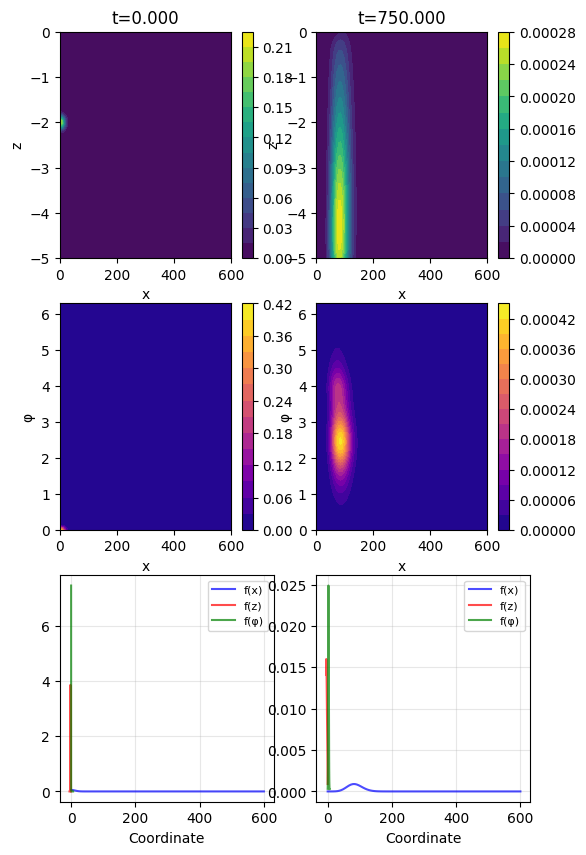

In [20]:
import time


print("="*60)
print("VECTORIZED 3D FOKKER-PLANCK SOLVER")
print("="*60)
print(f"Grid: {Nx}×{Nz}×{Nphi} = {Nx*Nz*Nphi:,} cells")
print(f"Resolution: dx={dx:.3f}, dz={dz:.3f}, dφ={dphi:.3f}")

print(f"Initial ∫f = {np.sum(f0)*dx*dz*dphi:.6f}")
print()

print(f"Time: t ∈ [0, {t_final}], dt={dt:.4e}, Nt={Nt}")
check_cfl_condition(x_grid, z_grid, phi_grid, dt)
print()

# Solve with live plotting
start_time = time.time()

# Set live_plot=True to see real-time updates (slower)
# Set live_plot=False for faster computation, then plot after

use_live_plot = False  # Change to True for live visualization

# solution = solve_fokker_planck_vectorized(f0, t_array, x_grid, z_grid, phi_grid,
#                                             bc_x='noflux', bc_z='noflux', bc_phi='periodic',
#                                             live_plot=use_live_plot, plot_interval=100, fast = False)

# solution = solve_fokker_planck_vectorized_implicit_phi(f0, t_array, x_grid, z_grid, phi_grid,
#                                             bc_x='open', bc_z='noflux', bc_phi='noflux',
#                                             live_plot=use_live_plot, plot_interval=100)
# solution = solve_fokker_planck_vectorized_implicit_phi_1(
#     f0, t_array, x_grid, z_grid, phi_grid,
#     bc_x='open', bc_z='noflux', bc_phi='noflux'
# )


solution, t_sub = solve_fokker_planck_numba(f0, t_array, x_grid, z_grid, phi_grid,
                                            bc_x='open', bc_z='open', bc_phi='periodic',
                                            live_plot=use_live_plot, plot_interval=100, save_interval=1, lower_mass_threshold=0.01)

# f = fokker_planck_step_IMEX_CC(
#         f, X, Z, PHI, t, dt, dx, dz, dphi,
#         bc_x, bc_z, bc_phi
#     )

elapsed = time.time() - start_time

print()
print("="*60)
print(f"✓ Done! Solution shape: {solution.shape}")
print(f"Final ∫f = {np.sum(solution[-1])*dx*dz*dphi:.6f}")
print(f"Computation time: {elapsed:.2f} seconds")
print(f"   ({elapsed/Nt:.4f} sec/step, {Nx*Nz*Nphi*Nt/elapsed/1e6:.2f} Mcells/sec)")
print("="*60)

# Create summary plots
print("\nGenerating summary plots...")
plot_summary(solution, t_array, x_grid, z_grid, phi_grid, 
                save_path=f'./Plots/fokker_planck_summary_{time.time()}.png')
print("Done")

A D = 0.001 is worse than D = 0.01

In [21]:
solution.shape

(12701, 100, 100, 50)

## Expected Path

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def get_expected_path(solution, t_saved, x_grid, z_grid):
    """
    Calculates the center of mass <x>(t) and <z>(t) from the 
    Fokker-Planck probability density evolution.
    
    Parameters
    ----------
    solution : ndarray (Nt, Nx, Nz, Nphi)
        The subsampled output from the FP solver.
    t_saved : ndarray (Nt)
        The time steps corresponding to the solution frames.
    x_grid, z_grid : ndarray
        The 1D spatial grids.
        
    Returns
    -------
    mu_x : ndarray
        Expected x position over time.
    mu_z : ndarray
        Expected z position over time.
    """
    Nt = len(t_saved)
    mu_x = np.zeros(Nt)
    mu_z = np.zeros(Nt)
    
    # Pre-calculate grid shapes for broadcasting if needed, 
    # but simple summation is safer and clearer.
    
    print(f"Extracting expected paths from {Nt} frames...")
    
    for n in range(Nt):
        f_t = solution[n] # Shape: (Nx, Nz, Nphi)
        
        # 1. Marginalize to get 1D distributions
        # Sum over axes (1, 2) -> (z, phi) to get P(x)
        # We don't strictly need dx/dz/dphi here because they cancel in the average
        p_x = np.sum(f_t, axis=(1, 2)) 
        
        # Sum over axes (0, 2) -> (x, phi) to get P(z)
        p_z = np.sum(f_t, axis=(0, 2))
        
        # 2. Calculate Center of Mass (Expectation Value)
        # <x> = Sum(x_i * p_i) / Sum(p_i)
        
        total_prob = np.sum(p_x)
        
        if total_prob > 1e-9:
            mu_x[n] = np.sum(x_grid * p_x) / total_prob
            mu_z[n] = np.sum(z_grid * p_z) / total_prob
        else:
            # Handle empty/finished simulation
            mu_x[n] = mu_x[n-1] if n > 0 else x_grid[0]
            mu_z[n] = mu_z[n-1] if n > 0 else z_grid[0]
            
    return mu_x, mu_z

# --- Execution ---

# 1. Calculate Paths
# Assumes 'sol_data' and 'sol_time' exist from the previous Numba solver cell
mean_x, mean_z = get_expected_path(solution, t_sub, x_grid, z_grid)



Extracting expected paths from 12701 frames...


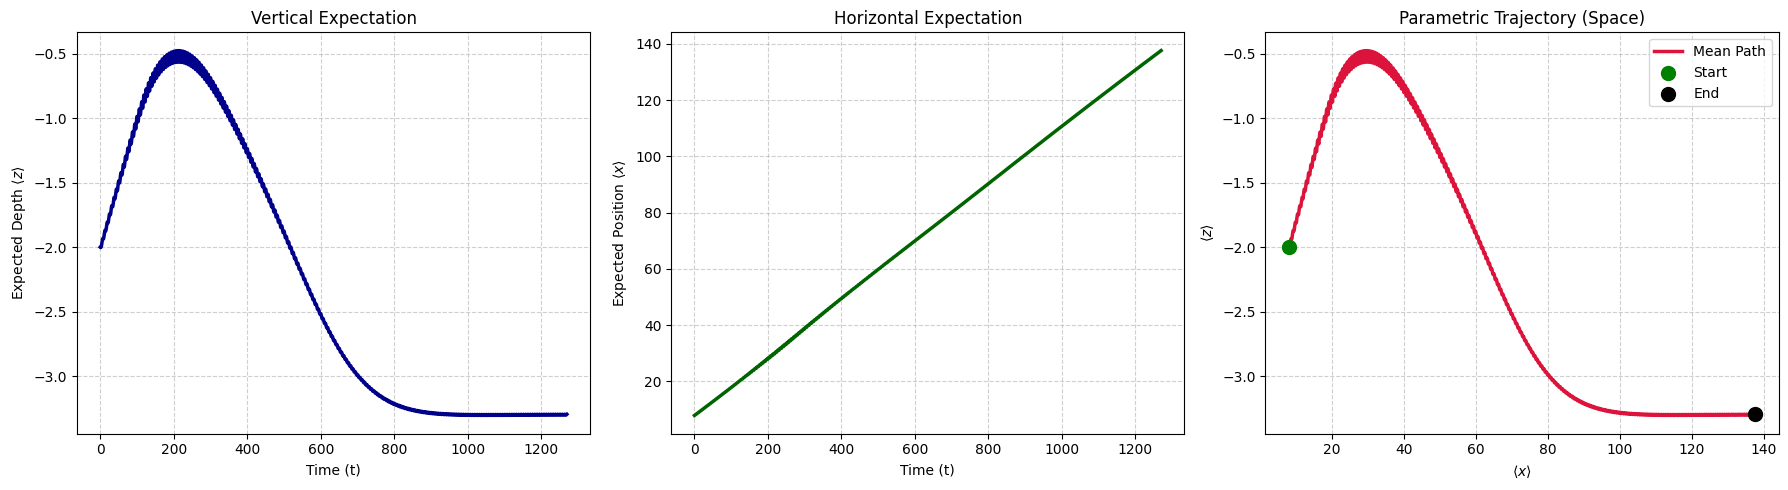

In [25]:
# --- Plotting ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Vertical Depth vs Time
ax[0].plot(t_sub, mean_z, color='darkblue', linewidth=2.5)
ax[0].set_xlabel('Time (t)')
ax[0].set_ylabel('Expected Depth $\\langle z \\rangle$')
ax[0].set_title('Vertical Expectation')
ax[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Horizontal Position vs Time
ax[1].plot(t_sub, mean_x, color='darkgreen', linewidth=2.5)
ax[1].set_xlabel('Time (t)')
ax[1].set_ylabel('Expected Position $\\langle x \\rangle$')
ax[1].set_title('Horizontal Expectation')
ax[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Parametric Path (Real Space Trajectory)
# Use a scatter for the start and end points
ax[2].plot(mean_x, mean_z, color='crimson', linewidth=2.5, label='Mean Path')
ax[2].scatter([mean_x[0]], [mean_z[0]], color='green', s=100, label='Start', zorder=5)
ax[2].scatter([mean_x[-1]], [mean_z[-1]], color='black', s=100, label='End', zorder=5)

ax[2].set_xlabel('$\\langle x \\rangle$')
ax[2].set_ylabel('$\\langle z \\rangle$')
ax[2].set_title('Parametric Trajectory (Space)')
ax[2].legend()
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].set_aspect('auto', adjustable='box') # Important to see true geometry

plt.tight_layout()
plt.show()

In [ ]:
check_cfl_condition(x_grid, z_grid, phi_grid, dt)

------------------------------
CFL Stability Analysis (dt = 1.00e-01)
------------------------------
Advection Limits (dt < ...):
  X:   1.44e+02 (v=2.10e-01)
  Z:   4.59e-01 (v=1.10e-01)
  Phi: 3.56e+00 (v=6.08e-02) <--- Check this!
Diffusion Limits (dt < ...):
  Phi: 2.35e+03
------------------------------
Combined Max Stable dt: 4.06e-01
✅ STABLE


0.40551861339496914